In [32]:
# -*- coding: utf-8 -*
import twitter
import csv
import json
import re
import requests
import lxml.html as html
from urllib2 import urlopen
import pandas as pd
from datetime import datetime, timedelta
from dateutil import tz
import time
import sklearn.cross_validation as cv
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [33]:
PREPARED_CSV = "prepared_to_analys.csv"
df = pd.read_csv(PREPARED_CSV, sep=",")
print df.columns

Index([u'index', u'comments', u'date', u'news_date', u'source', u'tags',
       u'title', u'type', u'url', u'views', u'created_at', u'is_retweet',
       u'screen_name', u'tw_id', u'user_favourites_count',
       u'user_followers_count', u'user_friends_count', u'user_listed_count',
       u'user_statuses_count', u'time_since_news', u'week_day_news',
       u'minutes_since_midnight', u'first_time_tweet', u'follower_sum',
       u'retweeted_count_sum', u'user_listed_count_sum', u'last_time_tweet',
       u'VC', u'forbes.ru', u'lenta.ru', u'lifenews.ru', u'meduza.io',
       u'navalny.com', u'ria.ru', u'roem.ru', u'slon.ru', u'vedomosti.ru',
       u'vesti.ru'],
      dtype='object')


In [34]:

# Удаляем лишние столбцы


df_features = ["url", "news_date", "week_day_news", "minutes_since_midnight", "first_time_tweet","follower_sum", "retweeted_count_sum", "user_listed_count_sum", "last_time_tweet", 'VC', 'forbes.ru', 'lenta.ru', 'lifenews.ru', 'meduza.io', 'navalny.com', 'ria.ru', 'roem.ru', 'slon.ru', 'vedomosti.ru', 'vesti.ru']
x_features = ["week_day_news", "minutes_since_midnight", "first_time_tweet","follower_sum", "retweeted_count_sum", "user_listed_count_sum",  'VC', 'forbes.ru', 'lenta.ru', 'lifenews.ru', 'meduza.io', 'navalny.com', 'ria.ru', 'roem.ru', 'slon.ru', 'vedomosti.ru', 'vesti.ru']
df = df[df_features]


"""
df_features = ["url", "first_time_tweet","retweeted_count_sum", 'VC', 'forbes.ru', 'lenta.ru', 'lifenews.ru', 'meduza.io', 'navalny.com', 'ria.ru', 'roem.ru', 'slon.ru', 'vedomosti.ru', 'vesti.ru', "last_time_tweet"]
x_features = ["url", "first_time_tweet","retweeted_count_sum",  'VC', 'forbes.ru', 'lenta.ru', 'lifenews.ru', 'meduza.io', 'navalny.com', 'ria.ru', 'roem.ru', 'slon.ru', 'vedomosti.ru', 'vesti.ru']
df = df[df_features]
""";

In [5]:
#df[df["roem.ru"]==1]

In [35]:
# С глубоким прискорбием удаляем NaN - если ничего не было, пока не будем будмать, что могло быть
df = df.drop_duplicates().dropna()

In [7]:
df.head()

,url,news_date,week_day_news,minutes_since_midnight,first_time_tweet,follower_sum,retweeted_count_sum,user_listed_count_sum,last_time_tweet,VC,forbes.ru,lenta.ru,lifenews.ru,meduza.io,navalny.com,ria.ru,roem.ru,slon.ru,vedomosti.ru,vesti.ru
0,https://vc.ru/n/reality-editor,2015-12-12 21:30,5,1290,2,62593,1,681,8,1,0,0,0,0,0,0,0,0,0,0
19,http://lifenews.ru/news/174843,2015-12-13 00:45,6,45,8,542470,2,3223,15,0,0,0,1,0,0,0,0,0,0,0
34,http://lifenews.ru/news/174840,2015-12-13 00:39,6,39,1,32,0,4,20,0,0,0,1,0,0,0,0,0,0,0
61,http://lifenews.ru/news/174841,2015-12-13 00:14,6,14,13,546416,7,3332,20,0,0,0,1,0,0,0,0,0,0,0
86,http://lifenews.ru/news/174838,2015-12-12 23:46,5,1426,27,595090,21,4327,71,0,0,0,1,0,0,0,0,0,0,0


In [8]:
# В итоге имеем:
len(df)

1579

In [9]:
df.head(1)

,url,news_date,week_day_news,minutes_since_midnight,first_time_tweet,follower_sum,retweeted_count_sum,user_listed_count_sum,last_time_tweet,VC,forbes.ru,lenta.ru,lifenews.ru,meduza.io,navalny.com,ria.ru,roem.ru,slon.ru,vedomosti.ru,vesti.ru
0,https://vc.ru/n/reality-editor,2015-12-12 21:30,5,1290,2,62593,1,681,8,1,0,0,0,0,0,0,0,0,0,0


In [10]:
"""
x = df[x_features].as_matrix()
y = df["last_time_tweet"].as_matrix()
""";

In [11]:
df[df["url"]=="https://vc.ru/n/reality-editor"]

,url,news_date,week_day_news,minutes_since_midnight,first_time_tweet,follower_sum,retweeted_count_sum,user_listed_count_sum,last_time_tweet,VC,forbes.ru,lenta.ru,lifenews.ru,meduza.io,navalny.com,ria.ru,roem.ru,slon.ru,vedomosti.ru,vesti.ru
0,https://vc.ru/n/reality-editor,2015-12-12 21:30,5,1290,2,62593,1,681,8,1,0,0,0,0,0,0,0,0,0,0


In [14]:
def splitByDate(date):
    train_df = df[df["news_date"] < date]
    test_df = df[df["news_date"] > date]
    print len(train_df), len(test_df)
    
    x_train = train_df[x_features].as_matrix()
    y_train = train_df["last_time_tweet"].as_matrix()
    
    x_test = test_df[x_features].as_matrix()
    y_test = test_df["last_time_tweet"].as_matrix()
    
    train_urls = train_df["url"].as_matrix()
    test_urls = test_df["url"].as_matrix()
    
    return x_train, x_test, y_train, y_test, train_urls, test_urls

In [14]:
df["news_date"].min(), df["news_date"].max()

('2015-12-12 06:17', '2015-12-17 09:50')

In [15]:
x_train, x_test, y_train, y_test, train_urls, test_urls = splitByDate("2015-12-16 09:50")

1199 379


In [57]:
x_train[0], y_train[0]

(array([  5.00000000e+00,   1.29000000e+03,   2.00000000e+00,
          6.25930000e+04,   1.00000000e+00,   6.81000000e+02,
          1.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00]), 8.0)

In [16]:
df.head()

,url,news_date,week_day_news,minutes_since_midnight,first_time_tweet,follower_sum,retweeted_count_sum,user_listed_count_sum,last_time_tweet,VC,forbes.ru,lenta.ru,lifenews.ru,meduza.io,navalny.com,ria.ru,roem.ru,slon.ru,vedomosti.ru,vesti.ru
0,https://vc.ru/n/reality-editor,2015-12-12 21:30,5,1290,2,62593,1,681,8,1,0,0,0,0,0,0,0,0,0,0
19,http://lifenews.ru/news/174843,2015-12-13 00:45,6,45,8,542470,2,3223,15,0,0,0,1,0,0,0,0,0,0,0
34,http://lifenews.ru/news/174840,2015-12-13 00:39,6,39,1,32,0,4,20,0,0,0,1,0,0,0,0,0,0,0
61,http://lifenews.ru/news/174841,2015-12-13 00:14,6,14,13,546416,7,3332,20,0,0,0,1,0,0,0,0,0,0,0
86,http://lifenews.ru/news/174838,2015-12-12 23:46,5,1426,27,595090,21,4327,71,0,0,0,1,0,0,0,0,0,0,0


In [19]:
x_train[1], y_train[1], train_urls[1]

(array([  3.00000000e+00,   5.43000000e+02,   1.60000000e+01,
          5.54794000e+05,   1.20000000e+01,   6.28200000e+03,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          1.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00]),
 32.0,
 'http://lifenews.ru/news/175560')

In [ ]:
"""
# Делим данные
x_train, x_test, y_train, y_test = cv.train_test_split(x, y, test_size=0.4)

x_train_urls = x_train.T[0]
x_test_url = x_test.T[0]
x_train = x_train.T[1:].T
x_test = x_test.T[1:].T
"""

In [20]:
print "Коэффициенты корреляции Y:"
for i in range(len(x_features)-1):
    x_column = x[:,i+1]
    print x_features[i+1], "=", np.corrcoef(x_column.astype('float'), y)[0][1]

Коэффициенты корреляции Y:
minutes_since_midnight = 0.0756119601139
first_time_tweet = 0.883519702743
follower_sum = 0.49818394105
retweeted_count_sum = 0.885528728229
user_listed_count_sum = 0.58596130179
VC = -0.0528678646962
forbes.ru = -0.0455315472219
lenta.ru = -0.327949178068
lifenews.ru = 0.305341053723
meduza.io = 0.106546412232
navalny.com = 0.333152935956
ria.ru = -0.119237167866
roem.ru = nan
slon.ru = 0.0231921197455
vedomosti.ru = -0.0346400716587
vesti.ru = -0.0454633052482


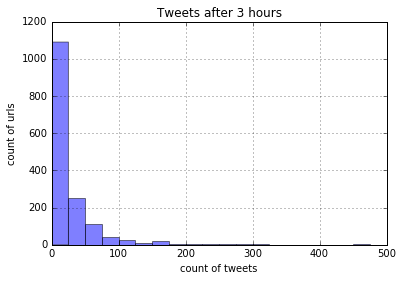

In [21]:
df.last_time_tweet.hist(alpha=0.5, bins=[i*25 for i in range(20)])
plt.title("Tweets after 3 hours")
plt.ylabel("count of urls")
plt.xlabel("count of tweets")
plt.show()

In [ ]:
#df.week_day_news.hist(alpha=0.5, bins=[i for i in range(7)])
"""
S = df.groupby("week_day_news")["last_time_tweet"].sum()
plt.pie(S.as_matrix(), labels=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]);
plt.show();
""";

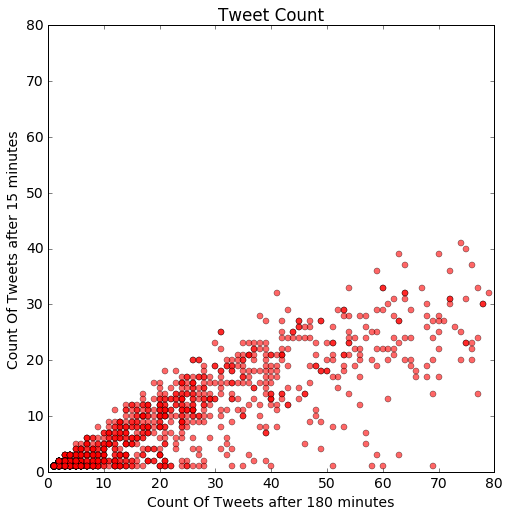

In [22]:
plt.figure(figsize=(8,8))
plt.plot(df["last_time_tweet"].as_matrix(), df["first_time_tweet"].as_matrix(), 'ro',  alpha=0.6)
plt.title("Tweet Count")
plt.xlabel("Count Of Tweets after 180 minutes")
plt.ylabel("Count Of Tweets after 15 minutes")
plt.xlim(0, 80)
plt.ylim(0, 80)
#plt.xscale('log')
#plt.yscale('log')
#plt.grid(b=True, which='both', color='0.65',linestyle='-')
plt.rcParams.update({'font.size': 14})

In [23]:
df[df["last_time_tweet"]> 90][["url", "first_time_tweet", "last_time_tweet"]].head()

,url,first_time_tweet,last_time_tweet
1379,http://lifenews.ru/news/175240,45,110
1586,http://lifenews.ru/news/175233,32,147
2136,http://lifenews.ru/news/175216,58,210
3470,https://slon.ru/posts/61277,95,277
3875,https://slon.ru/posts/61270,85,258


In [70]:
def plot(y_test, y_predicted, title="", text=""):
    plt.figure(figsize=(9,9))
    plt.plot(y_test, y_predicted, 'ro', label="predicted", alpha=0.7)
    plt.title(title)
    plt.xlabel("Y_TEST")
    plt.ylabel("Y_PREDICTED")
    
    max_y = max(max(y_test), max(y_predicted))+10
    
    plt.xlim(0, max_y)
    plt.ylim(0, max_y)
    #plt.legend()
    plt.text(0.05*max_y, max_y-0.05*max_y, "mse="+text, fontsize=15)
    
    plt.plot([0, max_y], [0, max_y], color='black', alpha=0.5)
    plt.grid(b=True, which='both', color='0.65',linestyle='-')
    
    plt.show()

In [25]:
def split_data(train_index, test_index):
    x_train = x[train_index]
    y_train = y[train_index]
    
    x_test = x[test_index]
    y_test = y[test_index]
    
    return x_train, x_test, y_train, y_test

In [26]:
#loo = cv.LeaveOneOut(len(y))

## Деревья

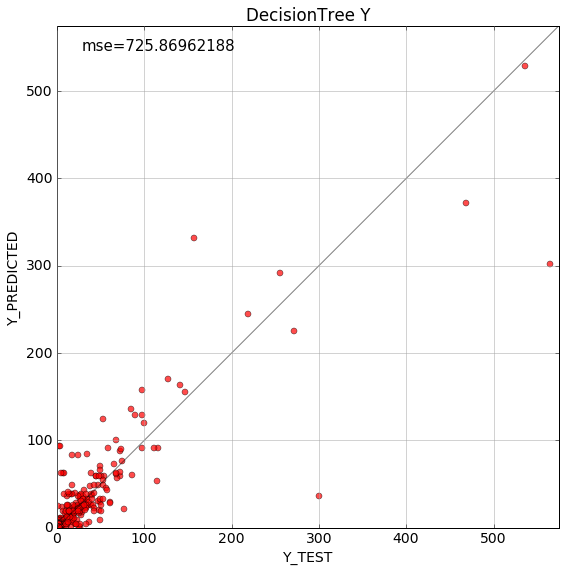

In [105]:
from sklearn.tree import DecisionTreeRegressor

dtree = DecisionTreeRegressor(max_depth=12)
dtree.fit(x_train, y_train)
y_predicted = dtree.predict(x_test)

mse = mean_squared_error(y_test, y_predicted)
plot(y_test, y_predicted, title="DecisionTree Y", text=str(mse))

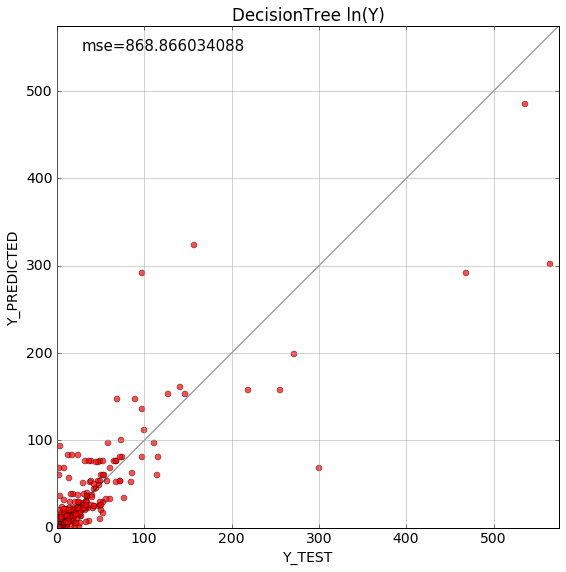

In [106]:
from sklearn.tree import DecisionTreeRegressor

dtree = DecisionTreeRegressor(max_depth=11)
dtree.fit(x_train, np.log(y_train))
y_predicted = dtree.predict(x_test)
y_predicted = np.exp(y_predicted)

mse = mean_squared_error(y_test, y_predicted)
plot(y_test, y_predicted, title="DecisionTree ln(Y)", text=str(mse))

В целом, конечно, дерево решений работает плохо, но выбросы оно вполне себе улавливает

### LinearRegression

In [107]:
from sklearn.linear_model import Ridge

Подбираем параметр

In [108]:
alpha = [0.01, 0.1, 1, 10, 1e2, 1e3, 1e4, 1e5, 2e5, 4e5, 8e5, 1e6, 2e6, 4e6, 7e6, 1e7, 1e8]

mse = []
for al in alpha:
        
    model = Ridge(alpha=al)
    model.fit(x_train, y_train)
    
    y_predicted = model.predict(x_test)
    
    cur_mse = mean_squared_error(y_test, y_predicted)
    #print cur_mse
    mse.append(cur_mse)

best_alpha = alpha[mse.index(min(mse))]
print "Best Aplha = ", best_alpha
#plot(y_true, y_predicted, title="DecisionTree Log(Y)")

Best Aplha =  10


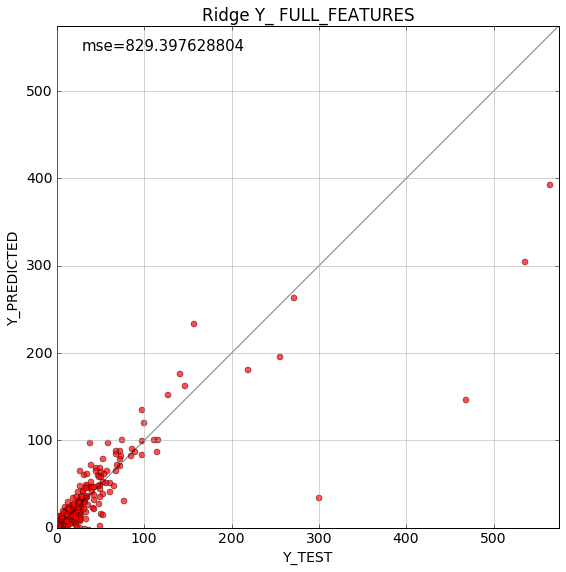

In [109]:
model = Ridge(alpha=best_alpha)
model.fit(x_train, y_train)
    
y_predicted = model.predict(x_test)
mse = mean_squared_error(y_test, y_predicted)
plot(y_test, y_predicted, title="Ridge Y_ FULL_FEATURES", text=str(mse))

In [110]:
model.coef_

array([ -1.59981884e-01,  -5.15413755e-03,   2.17949680e+00,
         1.13786680e-05,   1.11960371e+00,  -3.17911687e-03,
        -8.61971488e-01,   2.61975972e+00,  -3.80164935e+00,
        -1.14640376e+01,  -1.16890962e+01,   3.72624154e+01,
        -5.75074486e+00,   0.00000000e+00,  -2.25464847e+00,
        -4.29518685e+00,   2.35159673e-01])

In [111]:
df.head(1)

,url,news_date,week_day_news,minutes_since_midnight,first_time_tweet,follower_sum,retweeted_count_sum,user_listed_count_sum,last_time_tweet,VC,forbes.ru,lenta.ru,lifenews.ru,meduza.io,navalny.com,ria.ru,roem.ru,slon.ru,vedomosti.ru,vesti.ru
0,https://vc.ru/n/reality-editor,2015-12-12 21:30,5,1290,2,62593,1,681,8,1,0,0,0,0,0,0,0,0,0,0


Теперь логарифм

In [112]:
alpha = [0.01, 0.1, 1, 10, 1e2, 1e3, 1e4, 1e5, 2e5, 4e5, 8e5, 1e6, 2e6, 4e6, 7e6, 1e7, 1e8]

mse = []
for al in alpha:
        
    model = Ridge(alpha=al)
    model.fit(x_train, np.log(y_train))
    
    y_predicted = model.predict(x_test)
    y_predicted = np.exp(y_predicted)
    
    cur_mse = mean_squared_error(y_test, y_predicted)
    #print cur_mse
    mse.append(cur_mse)

best_alpha = alpha[mse.index(min(mse))]
print "Best Aplha = ", best_alpha
#plot(y_true, y_predicted, title="DecisionTree Log(Y)")

Best Aplha =  0.01


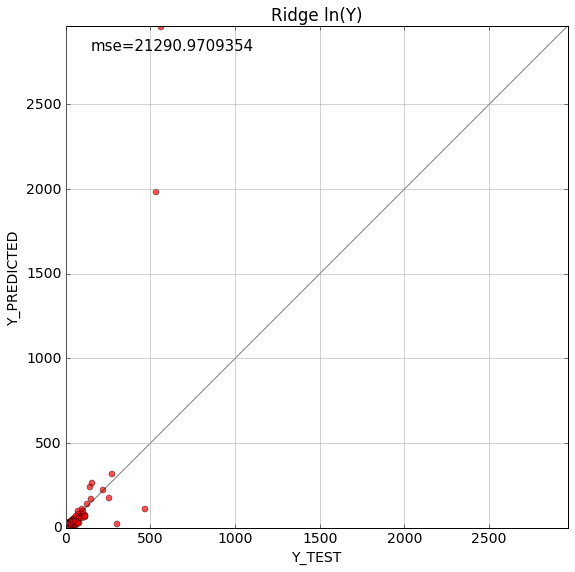

In [113]:
model = Ridge(alpha=best_alpha)
model.fit(x_train, np.log(y_train))
    
y_predicted = model.predict(x_test)
y_predicted = np.exp(y_predicted)
mse = mean_squared_error(y_test, y_predicted)
plot(y_test, y_predicted, title="Ridge ln(Y)", text=str(mse))

# RandomForest 

In [114]:
from sklearn.ensemble import RandomForestRegressor

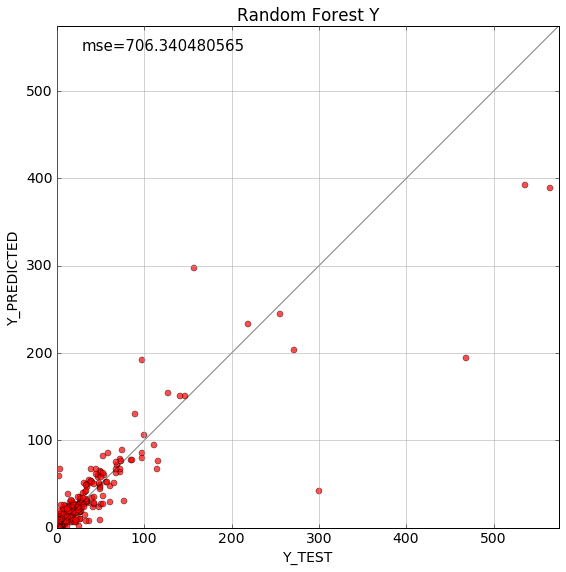

In [115]:
model = RandomForestRegressor(n_estimators=500, max_depth=20)
model.fit(x_train, (y_train))
y_predicted = model.predict(x_test)

mse = mean_squared_error(y_test, y_predicted)
plot(y_test, y_predicted, title="Random Forest Y", text=str(mse))

#### Теперь логарифм

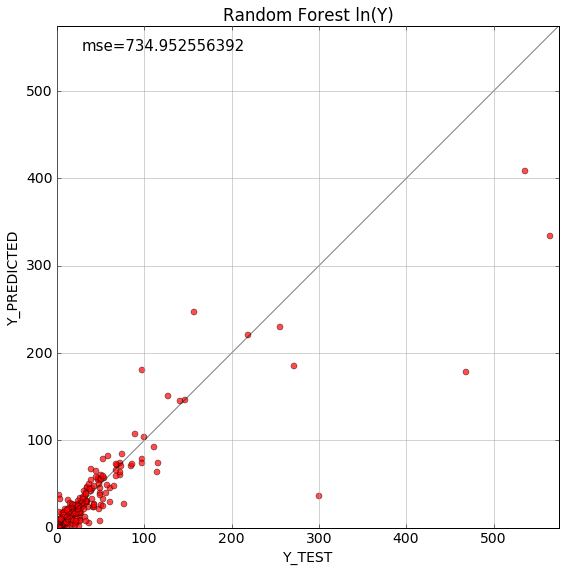

In [116]:
model = RandomForestRegressor(n_estimators=800, max_depth=12)
model.fit(x_train, np.log(y_train))
y_predicted = model.predict(x_test)
y_predicted = np.exp(y_predicted)

mse = mean_squared_error(y_test, y_predicted)
plot(y_test, y_predicted, title="Random Forest ln(Y)", text=str(mse))

# Gradient Boosting

In [117]:
from sklearn.ensemble import GradientBoostingRegressor

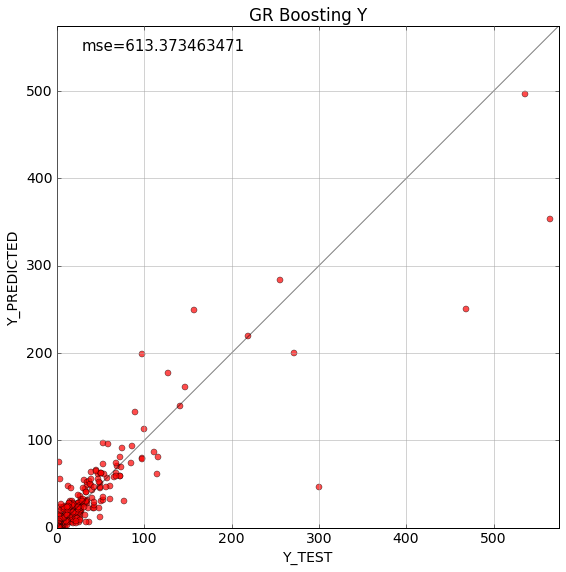

In [184]:
model = GradientBoostingRegressor(n_estimators=520, learning_rate=0.02, max_depth=10, min_samples_leaf=2, max_features=12, warm_start=True)
model.fit(x_train, y_train)
y_predicted = model.predict(x_test)
#y_predicted = np.exp(y_predicted)

mse = mean_squared_error(y_test, y_predicted)
plot(y_test, y_predicted, title="GR Boosting Y", text=str(mse))

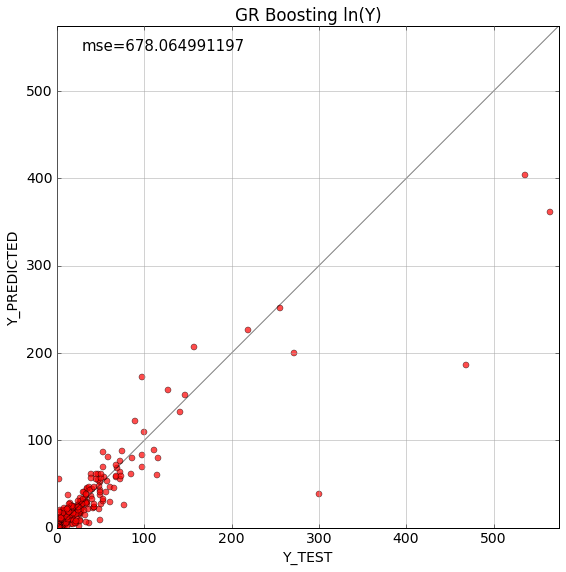

In [119]:
model = GradientBoostingRegressor(n_estimators=520, learning_rate=0.01, max_depth=10, min_samples_leaf=2, max_features=10, warm_start=True)
model.fit(x_train, np.log(y_train))
y_predicted = model.predict(x_test)
y_predicted = np.exp(y_predicted)

mse = mean_squared_error(y_test, y_predicted)
plot(y_test, y_predicted, title="GR Boosting ln(Y)", text=str(mse))

In [134]:
x_features

['week_day_news',
 'minutes_since_midnight',
 'first_time_tweet',
 'follower_sum',
 'retweeted_count_sum',
 'user_listed_count_sum',
 'VC',
 'forbes.ru',
 'lenta.ru',
 'lifenews.ru',
 'meduza.io',
 'navalny.com',
 'ria.ru',
 'roem.ru',
 'slon.ru',
 'vedomosti.ru',
 'vesti.ru']

In [143]:
test_urls = df["url"].values

In [144]:
predic = pd.Series(np.around(y_predicted))
lists = []
k = 0
for j in range(len(x_features[7:])):
    j = j+6
    print x_features[j]
    for i in range(len(y_test)):
        if (x_test[i][j] == 1):
            lists.append((test_urls[i], y_test[i], y_predicted[i], x_features[j]))
            k+=1
    
"""
df["predicted"]=predic
d = df.sort_values("last_time_tweet", ascending=False)
d[["url", "last_time_tweet", "predicted"]].head(20)
"""
print lists[200:205]

VC
forbes.ru
lenta.ru
lifenews.ru
meduza.io
navalny.com
ria.ru
roem.ru
slon.ru
vedomosti.ru
[]


In [148]:
lists

[('https://vc.ru/n/reality-editor', 8.0, 9.1661305648668083),
 ('http://lifenews.ru/news/174843', 15.0, 16.170607864178528),
 ('http://lifenews.ru/news/174840', 20.0, 24.43298499621898),
 ('http://lifenews.ru/news/174841', 20.0, 23.247538327269606),
 ('http://lifenews.ru/news/174838', 71.0, 44.662450638250569),
 ('http://lifenews.ru/news/174837', 40.0, 43.575707416922796),
 ('http://lifenews.ru/news/174835', 21.0, 29.329685790637527),
 ('http://lifenews.ru/news/174830', 23.0, 29.272039919196327),
 ('http://lifenews.ru/news/174834', 23.0, 24.129904178427392),
 ('http://lifenews.ru/news/174832', 20.0, 21.093416647673525),
 ('http://lifenews.ru/news/174831', 24.0, 23.454192933560936),
 ('http://www.vesti.ru/doc.html?id=2697559', 9.0, 6.1624564023440174),
 ('http://lenta.ru/news/2015/12/13/fire/', 1.0, 6.3706645686376335),
 ('http://lenta.ru/news/2015/12/13/moon/', 3.0, 7.5055513584859002),
 ('http://lenta.ru/news/2015/12/12/homs/', 1.0, 6.6430944092344273),
 ('http://lenta.ru/news/2015/12

In [186]:
df[df["url"] == "http://lifenews.ru/news/175454"]

,url,news_date,week_day_news,minutes_since_midnight,first_time_tweet,follower_sum,retweeted_count_sum,user_listed_count_sum,last_time_tweet,VC,forbes.ru,lenta.ru,lifenews.ru,meduza.io,navalny.com,ria.ru,roem.ru,slon.ru,vedomosti.ru,vesti.ru
24632,http://lifenews.ru/news/175454,2015-12-16 15:42,2,942,18,589555,16,3904,50,0,0,0,1,0,0,0,0,0,0,0


In [187]:
#lists.sort(key=lambda tup: tup[2], reverse=True)

df = pd.DataFrame(lists)
df.columns = ["link", "real after 180 min", "predicted", "type"]

In [188]:
r = df["type"].unique()

for type in r:
    print type
    ds = df[df["type"] == type]
    ds = ds.sort_values('predicted', ascending=False)
    ds.to_csv("SortedPredicted/"+type+".csv", sep=",", index=False, encoding="utf-8", quoting=csv.QUOTE_NONNUMERIC)

VC
forbes.ru
lenta.ru
lifenews.ru
meduza.io
navalny.com
ria.ru
slon.ru
vedomosti.ru


## Проверка

In [ ]:
df = pd.read_csv(PREPARED_CSV, sep=",")
df = df[["url", "week_day_news", "minutes_since_midnight", "first_time_tweet","follower_sum", "retweeted_count_sum", "favorite_count_sum", "user_listed_count_sum", "last_time_tweet", "views", "comments"]]
df = df.drop_duplicates().dropna()
df = df.reset_index()

In [ ]:
ltt = df["last_time_tweet"].as_matrix()
comments = df["comments"].as_matrix()
views = df["views"].as_matrix()

In [ ]:
np.corrcoef(views, ltt)

In [ ]:
np.corrcoef(comments, ltt)

In [ ]:
np.corrcoef(views, comments)

In [ ]:
m = np.mean(comments)

In [ ]:
np.corrcoef(views*np.exp(comments*0.5/m), ltt)

In [ ]:
df = pd.read_csv(PREPARED_CSV, sep=",")
df = df[["url", "week_day_news", "minutes_since_midnight", "first_time_tweet","follower_sum", "retweeted_count_sum", "favorite_count_sum", "user_listed_count_sum", "last_time_tweet", "views", "comments"]]
df = df.drop_duplicates().dropna()
df = df.reset_index()
ltt = df["last_time_tweet"].as_matrix()
comments = df["comments"].as_matrix()
views = df["views"].as_matrix()

In [68]:
def plot(y_test, y_predicted, labelX, labelY):
    plt.figure(figsize=(9,9))
    plt.plot(y_test, y_predicted, 'ro', label="predicted", alpha=0.7)
    #plt.title(title)
    plt.xlabel(labelX)
    plt.ylabel(labelY)

    max_y = max(max(y_true), max(y_predicted))+10

    #plt.xlim(0, max_y)
    #plt.ylim(0, max_y)
    plt.xscale('log')
    plt.yscale('log')
    #plt.legend()
    plt.text(0.05*max_y, max_y-0.05*max_y, "mse="+text, fontsize=15)

    #plt.plot([0, max_y], [0, max_y], color='black', alpha=0.5)
    #plt.grid(b=True, which='both', color='0.65',linestyle='-')

    plt.show()

In [ ]:
plot(ltt, comments, "Tweets after 180 minutes", "Comments")

In [ ]:
#plot(ltt, views, "Tweets after 180 minutes", "Views")
plt.figure(figsize=(9,9))
plt.plot(ltt, views, 'ro', label="predicted", alpha=0.7)
#plt.title(title)
plt.xlabel("Tweets after 180 minutes")
plt.ylabel("Views")
plt.xscale('log')
plt.yscale('log')
#max_y = max(max(y_true), max(y_predicted))+10
#plt.xlim(0, max_y)
#plt.ylim(0, max_y)
#plt.legend()
#plt.text(0.05*max_y, max_y-0.05*max_y, "mse="+text, fontsize=15)

#plt.plot([0, max_y], [0, max_y], color='black', alpha=0.5)
#plt.grid(b=True, which='both', color='0.65',linestyle='-')

plt.show()

In [ ]:
#plot(views, comments, "Views", "Comments")
#plot(ltt, views, "Tweets after 180 minutes", "Views")
plt.figure(figsize=(9,9))
plt.plot(views, comments, 'ro', label="predicted", alpha=0.7)
#plt.title(title)
plt.xlabel("Views")
plt.ylabel("Comments")
plt.xscale('log')
plt.yscale('log')
#max_y = max(max(y_true), max(y_predicted))+10
#plt.xlim(0, max_y)
#plt.ylim(0, max_y)
#plt.legend()
#plt.text(0.05*max_y, max_y-0.05*max_y, "mse="+text, fontsize=15)

#plt.plot([0, max_y], [0, max_y], color='black', alpha=0.5)
#plt.grid(b=True, which='both', color='0.65',linestyle='-')

plt.show()

(0, 83.0)

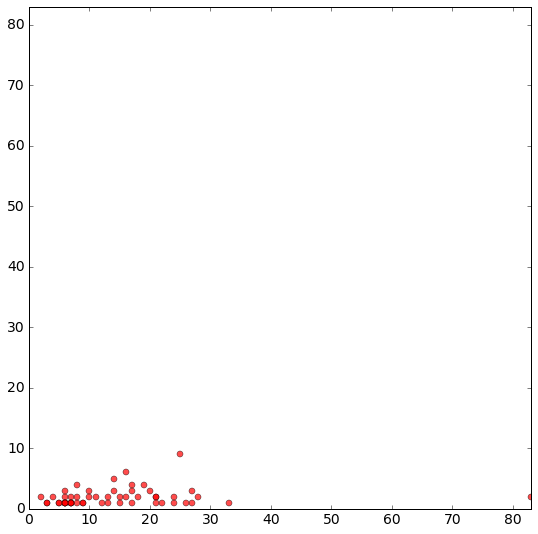

In [96]:
f = df[df["forbes.ru"]==1]["first_time_tweet"].values
l = df[df["forbes.ru"]==1]["last_time_tweet"].values

plt.figure(figsize=(9,9))
plt.plot(l, f, 'ro', label="last_first", alpha=0.7)

max_y = max(max(l), max(f))
plt.xlim(0, max_y)
plt.ylim(0, max_y)

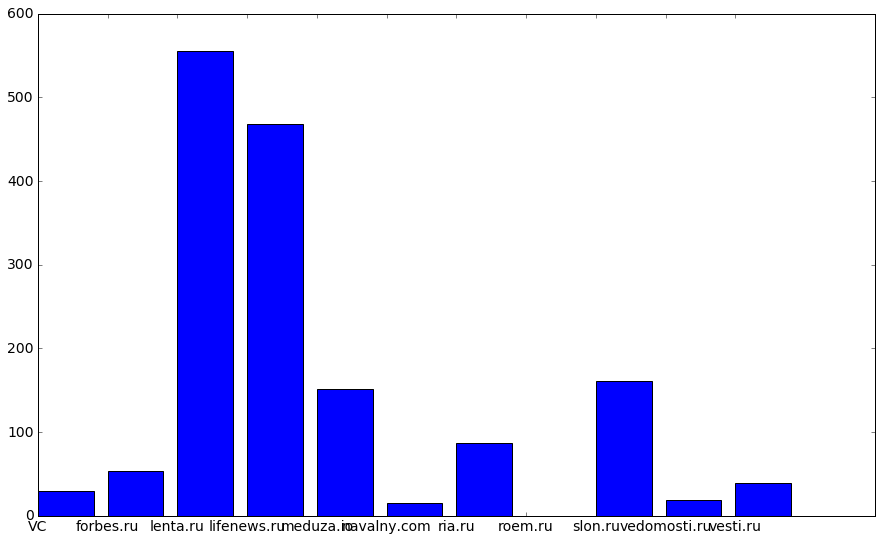

In [171]:
bar_sum = []
for name in df.columns[9:]:
    count = df[name].sum()
    bar_sum.append(count)
    
plt.figure(figsize=(15,9))
plt.bar(range(len(bar_sum)), bar_sum)
plt.xticks(range(len(bar_sum)), df.columns[9:])
plt.show()

In [251]:
news_type = x_features[6:]
bins = [i*20 for i in range(10)]
bar_data = []

for type_ in news_type:
    print type_
    type_array = df[df[type_] == 1]["last_time_tweet"].as_matrix()
    
    if not len(type_array):
        bar_data.append([]*len(bin))
    
    binned = pd.cut(type_array, bins)
    bar_data.append(pd.value_counts(binned))


VC
forbes.ru
lenta.ru
lifenews.ru
meduza.io
navalny.com
ria.ru
roem.ru
slon.ru
vedomosti.ru
vesti.ru


In [252]:
import re

def atoi(text):
    return int(text) if text.isdigit() else text

def natural_keys(text):
    '''
    alist.sort(key=natural_keys) sorts in human order
    http://nedbatchelder.com/blog/200712/human_sorting.html
    (See Toothy's implementation in the comments)
    '''
    return [ atoi(c) for c in re.split('(\d+)', text) ]


bar_df = pd.DataFrame(bar_data)
x_label = pd.DataFrame(bar_data).columns.tolist()
x_label.sort(key=natural_keys)
bar_df = bar_df[x_label]
x_label = bar_df.columns.tolist()
bar_data = bar_df.as_matrix()

array([[ 306,    0,    3,    1,    0,    0,    0,    0,    0],
       [ 464,   14,    0,    1,    1,    0,    0,   31,    6],
       [2857,   31,   17,   14,    6,    6,    3,    7,    4],
       [1605,  414,  136,   60,   31,   23,   16,   13,    6],
       [ 686,   84,   38,   15,   11,    5,    5,    8,    8],
       [  34,    6,   13,    6,    2,    1,    1,    1,    0],
       [1052,    8,    9,   20,    2,    1,    8,    2,    1],
       [  22,    0,    0,    0,    0,    0,    0,    0,    0],
       [ 724,   48,   15,   13,    4,    2,    3,    3,    3],
       [ 247,    4,    2,    4,    0,    1,    1,    0,    0],
       [1765,   12,    9,    6,    4,    5,    5,    2,    6]])

In [241]:
news_type

['VC',
 'forbes.ru',
 'lenta.ru',
 'lifenews.ru',
 'meduza.io',
 'navalny.com',
 'ria.ru',
 'roem.ru',
 'slon.ru',
 'vedomosti.ru',
 'vesti.ru']

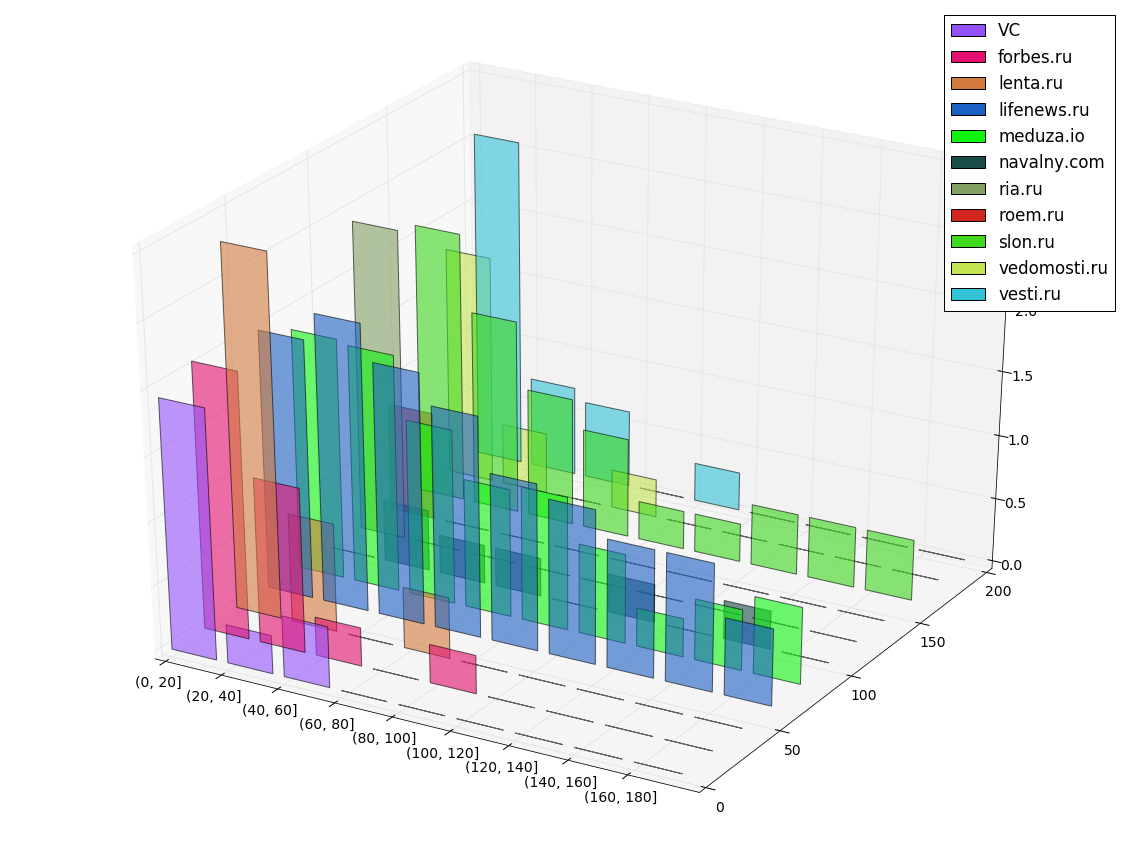

In [402]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

colors = []
proxys = []
fig = plt.figure(figsize=(20,15))
ax = fig.add_subplot(111,projection='3d')
#ax.set_yscale('log')
bottom = np.zeros(len(bar_data[0]))


for i in range(len(bar_data)):
    #ax.bar(x, z,width=0.2,
    colors.append(np.random.rand(3,1))
    ax.bar(range(len(bar_data[i])), np.log10(bar_data[i]+1), zs=20*i, zdir='y', alpha=0.6, color=colors[i], label=news_type[i]) #the green bar has the smallest width as it is contained within the other two
    proxys.append(plt.Rectangle((0, 0), 1, 1, fc=colors[i]))
    
    #bottom += bar_data[i]
    
plt.xticks([i for i in range(len(x_label))], x_label);
#ax.yaxis.set_scale('log')
#ax.title("Tweets after 180 minutes")
#ax.legend(news_type)
#ax.w_xscale.set_scale('log')
blue_proxy = plt.Rectangle((0, 0), 1, 1, fc="b")
red_proxy = plt.Rectangle((0, 0), 1, 1, fc="r")
ax.legend(proxys,news_type)
#ax.xticks([i+0.5 for i in range(len(x_label))], x_label)

In [278]:
(df[(df["last_time_tweet"] > 20) & (df["last_time_tweet"] < 40) & (df["forbes.ru"] == 1)])

,url,news_date,week_day_news,minutes_since_midnight,first_time_tweet,follower_sum,retweeted_count_sum,user_listed_count_sum,last_time_tweet,VC,forbes.ru,lenta.ru,lifenews.ru,meduza.io,navalny.com,ria.ru,roem.ru,slon.ru,vedomosti.ru,vesti.ru
2459,http://www.forbes.ru/news/308403-ofitsialnyi-k...,2015-12-15 14:35,1,875,2,18110,1,154,21,0,1,0,0,0,0,0,0,0,0,0
2538,http://www.forbes.ru/news/308395-sud-ispanii-p...,2015-12-15 13:47,1,827,NaN,NaN,NaN,NaN,21,0,1,0,0,0,0,0,0,0,0,0
2622,http://www.forbes.ru/news/308385-putin-zamoroz...,2015-12-15 12:32,1,752,3,18198,2,160,27,0,1,0,0,0,0,0,0,0,0,0
2655,http://www.forbes.ru/news/308381-ssha-budut-iz...,2015-12-15 12:06,1,726,2,18118,1,151,21,0,1,0,0,0,0,0,0,0,0,0
19977,http://www.forbes.ru/news/308291-tsena-barrely...,2015-12-14 15:05,0,905,1,18028,0,150,24,0,1,0,0,0,0,0,0,0,0,0
20048,http://www.forbes.ru/mneniya-column/gosplan/30...,2015-12-14 13:21,0,801,NaN,NaN,NaN,NaN,34,0,1,0,0,0,0,0,0,0,0,0
20277,http://www.forbes.ru/news/308269-sud-otkazalsy...,2015-12-14 13:00,0,780,1,18029,0,151,27,0,1,0,0,0,0,0,0,0,0,0
20332,http://www.forbes.ru/news/308261-serdyukov-vos...,2015-12-14 12:32,0,752,1,18029,0,151,21,0,1,0,0,0,0,0,0,0,0,0
25050,http://www.forbes.ru/news/308533-alfa-bank-spr...,2015-12-16 16:51,2,1011,NaN,NaN,NaN,NaN,27,0,1,0,0,0,0,0,0,0,0,0
25088,http://www.forbes.ru/news/308531-pomidory-za-n...,2015-12-16 16:50,2,1010,2,19239,1,172,24,0,1,0,0,0,0,0,0,0,0,0


In [273]:
np.random.rand(3,1)

array([[ 0.6855679 ],
       [ 0.92177097],
       [ 0.37616043]])

In [363]:
first = bar_data.T[0]

In [367]:
news_type

['VC',
 'forbes.ru',
 'lenta.ru',
 'lifenews.ru',
 'meduza.io',
 'navalny.com',
 'ria.ru',
 'roem.ru',
 'slon.ru',
 'vedomosti.ru',
 'vesti.ru']

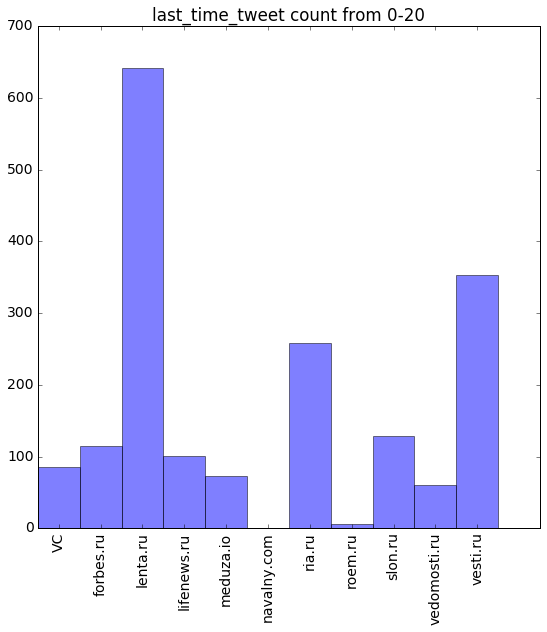

In [378]:
plt.figure(figsize=(9,9))
plt.bar(range(len(first)), first, alpha=0.5, width=1)
plt.xticks([i+0.5 for i in range (len(news_type))], news_type, rotation='vertical')
plt.rcParams.update({'font.size': 14})
plt.title("last_time_tweet count from 0-20")

# Leave-One-Out Cross-Validation

In [40]:
from sklearn import cross_validation
from sklearn.ensemble import GradientBoostingRegressor

In [41]:
x = df[x_features].as_matrix()
y = df["last_time_tweet"].as_matrix()

In [42]:
len(x[0])

17

In [65]:
loo = cross_validation.LeaveOneOut(len(y))

y_test_array = []
y_predicted_array = []
i = 0
for train_index, test_index in loo:
    x_train = x[train_index]
    y_train = y[train_index]
    x_test = x[test_index]
    y_test = y[test_index]
    
    model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.02, max_depth=10, min_samples_leaf=2, max_features=12, warm_start=True)
    model.fit(x_train, y_train)
    
    y_predicted = model.predict(x_test)
    
    y_test_array.append(y_test)
    y_predicted_array.append(y_predicted)
    
    i+=1
    if (i%10 == 0):
        print "Выполнено {} итераций".format(i)
    
"""
model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.02, max_depth=10, min_samples_leaf=2, max_features=12, warm_start=True)
model.fit(x_train, y_train)
y_predicted = model.predict(x_test)

mse = mean_squared_error(y_test, y_predicted)
plot(y_test, y_predicted, title="GR Boosting Y", text=str(mse))
"""

Выполнено 10 итераций
Выполнено 20 итераций
Выполнено 30 итераций
Выполнено 40 итераций
Выполнено 50 итераций
Выполнено 60 итераций
Выполнено 70 итераций
Выполнено 80 итераций
Выполнено 90 итераций
Выполнено 100 итераций
Выполнено 110 итераций
Выполнено 120 итераций
Выполнено 130 итераций
Выполнено 140 итераций
Выполнено 150 итераций
Выполнено 160 итераций
Выполнено 170 итераций
Выполнено 180 итераций
Выполнено 190 итераций
Выполнено 200 итераций
Выполнено 210 итераций
Выполнено 220 итераций
Выполнено 230 итераций
Выполнено 240 итераций
Выполнено 250 итераций
Выполнено 260 итераций
Выполнено 270 итераций
Выполнено 280 итераций
Выполнено 290 итераций
Выполнено 300 итераций
Выполнено 310 итераций
Выполнено 320 итераций
Выполнено 330 итераций
Выполнено 340 итераций
Выполнено 350 итераций
Выполнено 360 итераций
Выполнено 370 итераций
Выполнено 380 итераций
Выполнено 390 итераций
Выполнено 400 итераций
Выполнено 410 итераций
Выполнено 420 итераций
Выполнено 430 итераций
Выполнено 440 итерац

'\nmodel = GradientBoostingRegressor(n_estimators=100, learning_rate=0.02, max_depth=10, min_samples_leaf=2, max_features=12, warm_start=True)\nmodel.fit(x_train, y_train)\ny_predicted = model.predict(x_test)\n\nmse = mean_squared_error(y_test, y_predicted)\nplot(y_test, y_predicted, title="GR Boosting Y", text=str(mse))\n'

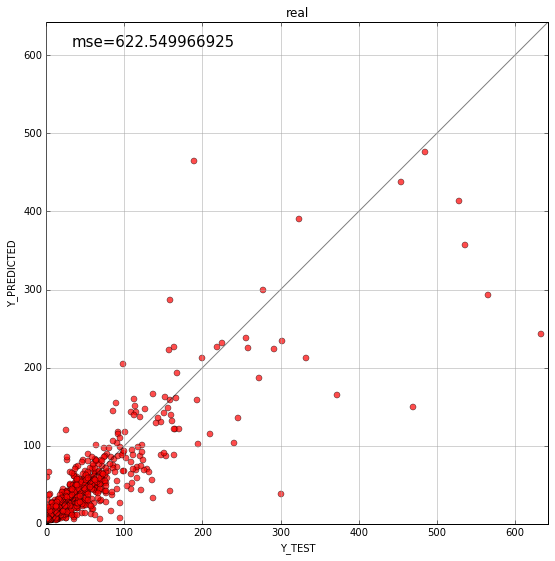

In [74]:
plot(y_test_array, y_predicted_array, "real", str(mean_squared_error(y_test_array, y_predicted_array)))

In [77]:
df["last_time_tweet"]

0          8
19        15
34        20
61        20
86        71
180       40
226       21
253       23
279       23
310       20
332       24
417        9
445        1
446        3
453        1
460       16
497        5
509        3
513        2
519       20
621        4
629        3
632        2
634        1
638       31
684        3
707        1
739        7
750       35
788       30
        ... 
66266     12
66282    118
66418     14
66432     63
66504     33
66539     24
66575      1
66579      2
66593      1
66608      1
66609      1
66643      1
66644      2
66646      2
66648      2
66651      3
66662      1
66663      2
66666      1
66678      1
66679      2
66682      1
66687      1
66723      1
66728      2
66730      5
66735      2
66737      2
66739      1
66751      3
Name: last_time_tweet, dtype: float64

In [118]:
def plot_with_color(y_test, y_predicted, title="", text=""):
    plt.figure(figsize=(9,9))
    plt.plot(y_test, y_predicted, 'o', color=np.random.rand(3,1), label="predicted", alpha=0.5)
    plt.title(title)
    plt.xlabel("Y_TEST")
    plt.ylabel("Y_PREDICTED")
    
    if (len(y_test)):
        max_y = max(max(y_test), max(y_predicted))+10

        plt.xlim(0, max_y)
        plt.ylim(0, max_y)
        #plt.legend()
        plt.text(0.05*max_y, max_y-0.05*max_y, "mse="+text, fontsize=15)

        plt.plot([0, max_y], [0, max_y], color='black', alpha=0.5)
        plt.grid(b=True, which='both', color='0.65',linestyle='-')

    #plt.show()

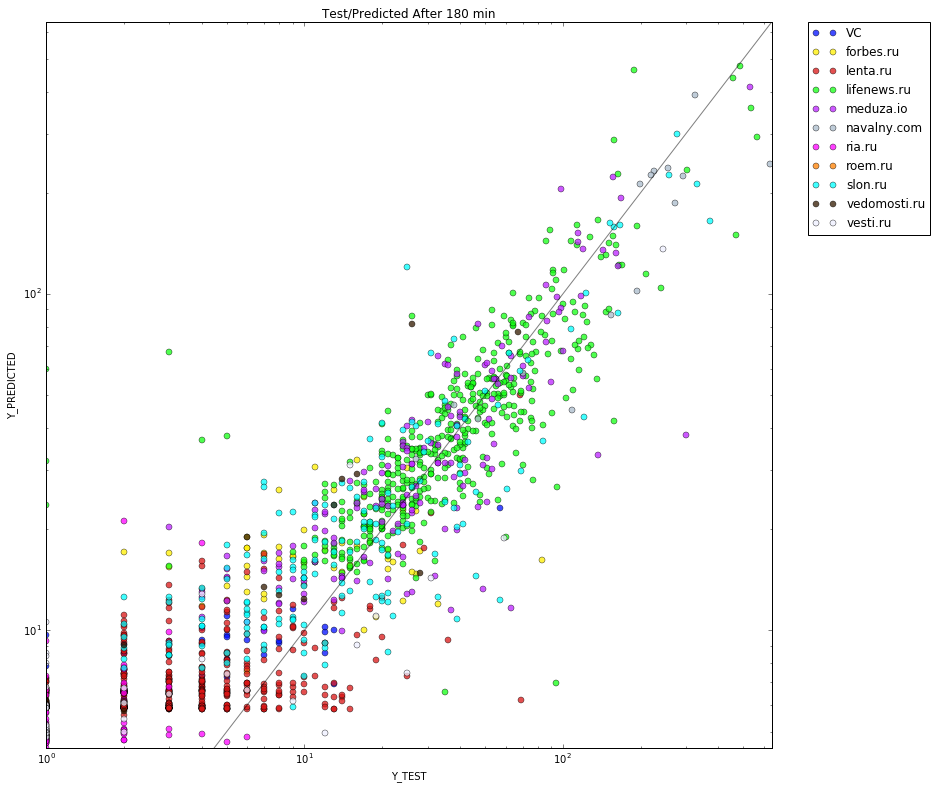

In [211]:
cites = df.columns[9:]
y_test_array = np.array(y_test_array)
y_predicted_array = np.array(y_predicted_array)
plt.figure(figsize=(13,13))

color_id = 0

colors = ['#000fff', '#fff000', '#DA1616','#14FF14','#BB22ff','#AABBCC','#FF00FF','#FF8000', '#00FFFF','#331A00','#eeefff','#eeefff','#eeefff']

for cite in cites:
    array = np.array(df[cite] == 1)
    test = y_test_array[array]
    predicted = y_predicted_array[array]
    
    plt.plot(test, predicted, 'o', color=colors[color_id], label=cite, alpha=0.75)
    color_id += 1
    
plt.xscale('log')
plt.yscale('log')
plt.title("Test/Predicted After 180 min")
plt.xlabel("Y_TEST")
plt.ylabel("Y_PREDICTED")

max_y = max(max(y_test_array), max(y_predicted_array))+10

plt.xlim(0, max_y)
plt.ylim(0, max_y)

plt.plot([0, max_y], [0, max_y], color='black', alpha=0.5)
#plt.grid(b=True, which='both', color='0.65',linestyle='-')
#plt.legend()
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    
plt.show()

In [178]:
test_urls = df["url"].values
lists = []
#["vc.ru", 
sites = ['vc.ru', 'forbes.ru', 'lenta.ru', 'lifenews.ru', 'meduza.io', 'navalny.com', 'ria.ru', 'roem.ru', 'slon.ru', 'vedomosti.ru', 'vesti.ru']
for i in range(len(test_urls)):
    for site in sites:
        if site in test_urls[i]:
            type_ = site
    lists.append((test_urls[i], y_test_array[i][0], y_predicted_array[i][0], type_))
    
list_df = pd.DataFrame(lists)
list_df.columns = ["url", "y_test", "y_predicted", "type"]


In [183]:
type_list = list_df["type"].unique()
for typ in type_list:
    ds = list_df[list_df["type"]==typ]
    ds = ds.sort_values("y_predicted", ascending=False)
    ds.to_csv("SortedPredicted/"+typ+".csv", sep=",", index=False, encoding="utf-8", quoting=csv.QUOTE_NONNUMERIC)